## Simple MTBD with moment-mediated mean-field interaction

In [119]:
import jax
import jax.numpy as jnp
import diffrax as dx
import equinox as eqx
import jaxopt
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib import colors

jax.config.update("jax_enable_x64", True)

In [120]:
d = 5

Particle-wise birth and death rates

In [121]:
λ = 1.0 * jnp.ones(d)
λ = λ.at[0].mul(2)
μ = 0.1 * jnp.ones(d)

Type transition rate matrix

In [122]:
Γ = jax.scipy.linalg.toeplitz(jnp.exp(-1.0 * jnp.arange(d)))
Γ = Γ.at[jnp.arange(d), jnp.arange(d)].set(0)
Γ = Γ.at[jnp.arange(d), jnp.arange(d)].set(-Γ.sum(1))

Plot $\lambda$, $\mu$, and $\Gamma$

In [123]:
Γ

Array([[-0.57131743,  0.36787944,  0.13533528,  0.04978707,  0.01831564],
       [ 0.36787944, -0.92088123,  0.36787944,  0.13533528,  0.04978707],
       [ 0.13533528,  0.36787944, -1.00642945,  0.36787944,  0.13533528],
       [ 0.04978707,  0.13533528,  0.36787944, -0.92088123,  0.36787944],
       [ 0.01831564,  0.04978707,  0.13533528,  0.36787944, -0.57131743]],      dtype=float64)

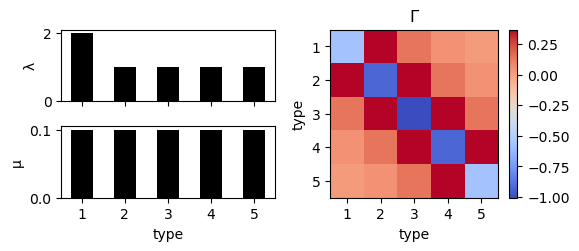

In [135]:
fig = plt.figure(figsize=(6, 2.5))

ax0 = plt.subplot2grid((2, 2), (0, 0))  # for ax[0]
ax1 = plt.subplot2grid((2, 2), (1, 0))  # for ax[1]
ax2 = plt.subplot2grid((2, 2), (0, 1), rowspan=2)  # for ax[2]

type_names = range(1, d + 1)

ax0.bar(type_names, λ, color="k", width=0.5)
ax0.set_xticklabels([])
ax0.set_ylabel("λ")

ax1.bar(type_names, μ, color="k", width=0.5)
ax1.set_xticks(type_names)
ax1.set_xlabel("type")
ax1.set_ylabel("μ")

cmap = ax2.imshow(Γ, cmap="coolwarm")
ax2.set_xticks(range(d))
ax2.set_xticklabels(type_names)
ax2.set_yticks(range(d))
ax2.set_yticklabels(type_names)
ax2.set_xlabel("type")
ax2.set_ylabel("type")
ax2.set_title("Γ")

cmap = fig.colorbar(cmap, ax=ax2, shrink=1.0)

plt.tight_layout()
plt.savefig("output/params.pdf")
plt.show()


Weights on the death rate modifier.

$$
\|W\|_{\mathrm{F}} = 0.1
$$

Case 1: capacity constraint

$$
W \propto \begin{bmatrix}
1 & 1 & 1 & 1 & 1 \\
1 & 1 & 1 & 1 & 1 \\
1 & 1 & 1 & 1 & 1 \\
1 & 1 & 1 & 1 & 1 \\
1 & 1 & 1 & 1 & 1 \\
\end{bmatrix}
$$

Case 1: negative frequency-dependent selection

$$
W \propto \begin{bmatrix}
1 &   &   &   &   \\
  & 1 &   &   &   \\
  &   & 1 &   &   \\
  &   &   & 1 &   \\
  &   &   &   & 1 \\
\end{bmatrix}
$$

In [125]:
# W = jnp.zeros(d)
# W = jnp.ones((d, d))
# W = jnp.eye(d)
W = (jnp.ones((d, d)) - 0.6 * jnp.eye(d))

W = 0.01 * W / jnp.linalg.norm(W)

W

Array([[0.00087706, 0.00219265, 0.00219265, 0.00219265, 0.00219265],
       [0.00219265, 0.00087706, 0.00219265, 0.00219265, 0.00219265],
       [0.00219265, 0.00219265, 0.00087706, 0.00219265, 0.00219265],
       [0.00219265, 0.00219265, 0.00219265, 0.00087706, 0.00219265],
       [0.00219265, 0.00219265, 0.00219265, 0.00219265, 0.00087706]],      dtype=float64)

We model the process on the interval $[0,\tau]$.

In [126]:
τ = 10.0

We'll take the stationary state of the type transition rate matrix as the initial condition $\mathbf{r}_0$.

In [127]:
M_aug = jnp.vstack((Γ.T[:-1], jnp.ones(d)))
b = jnp.concatenate((jnp.zeros(d - 1), jnp.array([1])))
r0 = jnp.linalg.solve(M_aug, b)
r0

Array([0.2, 0.2, 0.2, 0.2, 0.2], dtype=float64)

In [128]:
@jax.jit
def f(t, v, φ):
    return (jnp.diag(λ - (μ + W @ φ.evaluate(t))) + Γ) @ v

In [129]:
@jax.jit
def 𝒯(φ):
    return dx.diffeqsolve(dx.ODETerm(f), dx.Kvaerno5(), 0.0, τ, 1e-3 * τ, r0, args=φ,
                          saveat=dx.SaveAt(dense=True),
                          stepsize_controller=dx.PIDController(rtol=1e-8, atol=1e-8),
                          max_steps=100000)

We'll use the solution of the free system (without mean-field interaction) for the initial field trajectory.

In [130]:
class FreeSolution(eqx.Module):
    def evaluate(self, t):
        A = jax.scipy.linalg.expm((jnp.diag(λ - μ) + Γ) * t)
        return A @ r0
    
class LinearSolution(eqx.Module):
    slope: float
    def evaluate(self, t):
        return self.slope * r0 * t

The transcendental equation for the critical field

In [131]:
def criticality(φ):
    return (jnp.diag(λ - (μ + W @ φ)) + Γ) @ φ

In [132]:
time_grid = jnp.linspace(0.0, τ, 1000)

In [133]:
φ = FreeSolution()
# φ = LinearSolution(slope=10.0)
converged = False
tol = 1e-6
max_iter = 1000
for i in range(max_iter):
    φ_old = φ
    φ = 𝒯(φ)
    φ_old_sample = jax.vmap(φ_old.evaluate)(time_grid)
    φ_sample = jax.vmap(φ.evaluate)(time_grid)
    error = jnp.linalg.norm((jnp.log(φ_sample) - jnp.log(φ_old_sample)) / jnp.log(φ_old_sample), ord="fro")
    assert not jnp.isnan(φ_sample).any(), φ_sample
    if error < tol:
        print(f"Converged to error {error:.2e} < {tol:.2e} after {i} iterations")
        converged = True
        break
if not converged:
    print(f"Did not converge: error = {error:.2e} after {i} iterations")

critical_solver = jaxopt.ScipyRootFinding(method="hybr", optimality_fun=criticality)
φ_critical, state = critical_solver.run(φ.evaluate(τ))
assert state.success

Converged to error 3.85e-07 < 1.00e-06 after 31 iterations


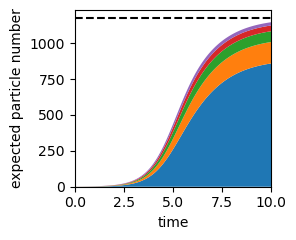

In [134]:
plt.figure(figsize=(3, 2.5))

plt.stackplot(time_grid, jax.vmap(φ.evaluate)(time_grid).T)
plt.axhline(φ_critical.sum(), color="black", ls="--")
plt.xlabel("time")
plt.ylabel("expected particle number")
plt.xlim(0, τ)
plt.ylim(0, 1.05 * φ_critical.sum())

plt.tight_layout()
# plt.savefig("output/free.pdf")
# plt.savefig("output/capacity.pdf")
# plt.savefig("output/nfds.pdf")
plt.savefig("output/pfds.pdf")
plt.show()